In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# pd.set_option('display.max_colwidth', 150000) # view everything
import sys
sys.path.insert(1, '../')
import research
from research import nlp_eda
import re

In [2]:
paths = {'all_data': '../data/merged_df.csv'}
all_data = pd.read_csv(paths['all_data'], index_col = 0)

In [3]:
all_data.head()

,Description,Location,Job Title
0,\n\n\nThis position can be based remotely anyw...,new york,data scientist
1,\n\nSummary\n \nImagine what you could do here...,texas,data scientist
2,\nLead analytics and measurement efforts for s...,other,data scientist
3,"\nAbout Gusto\n\nGusto is a modern, online peo...",other,data scientist
4,"\n\nSummary\n \nAt Apple, new ideas have a way...",texas,data scientist


In [4]:
all_data.shape

(1703, 3)

In [5]:
# Creating an object where my NLP EDA functions are located
nlp = nlp_eda()

In [6]:
def preprocess(seq):
    ''' Preprocessing pipeline '''
    
    # Removing punctuation and lower casing
    seq = seq.map(lambda x: re.sub('[,\.!?]', '', x))
    
    return seq

In [7]:
seq = preprocess(all_data['Description'])

In [8]:
seq

0      \n\n\nThis position can be based remotely anyw...
1      \n\nSummary\n \nImagine what you could do here...
2      \nLead analytics and measurement efforts for s...
3      \nAbout Gusto\n\nGusto is a modern online peop...
4      \n\nSummary\n \nAt Apple new ideas have a way ...
                             ...                        
355    The New York Post is searching for a web analy...
356    The Metro Group Inc is an established successf...
357    It's fun to work in a company where people tru...
358    Summary\nThe Business Intelligence (BI) Soluti...
359    Location: New York New York / Global\nAbout In...
Name: Description, Length: 1703, dtype: object

In [9]:
# help(a)

/Users/mtaruno/opt/anaconda3/envs/cannon/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


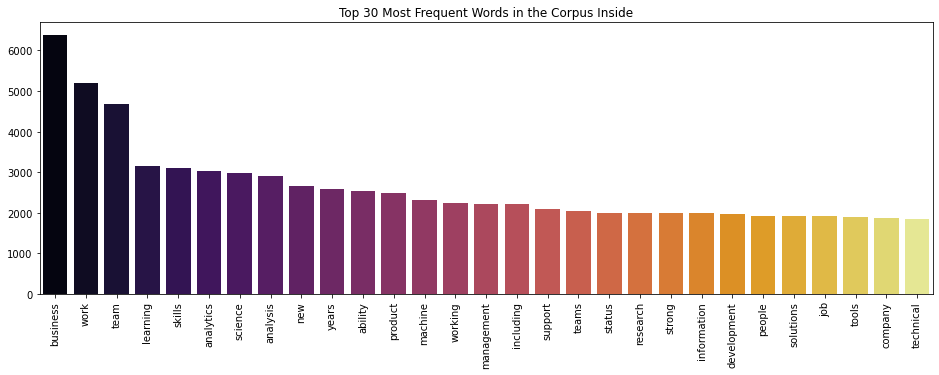

In [10]:
# Visualizing the descriptions of my data
nlp.visualize_counts(seq)

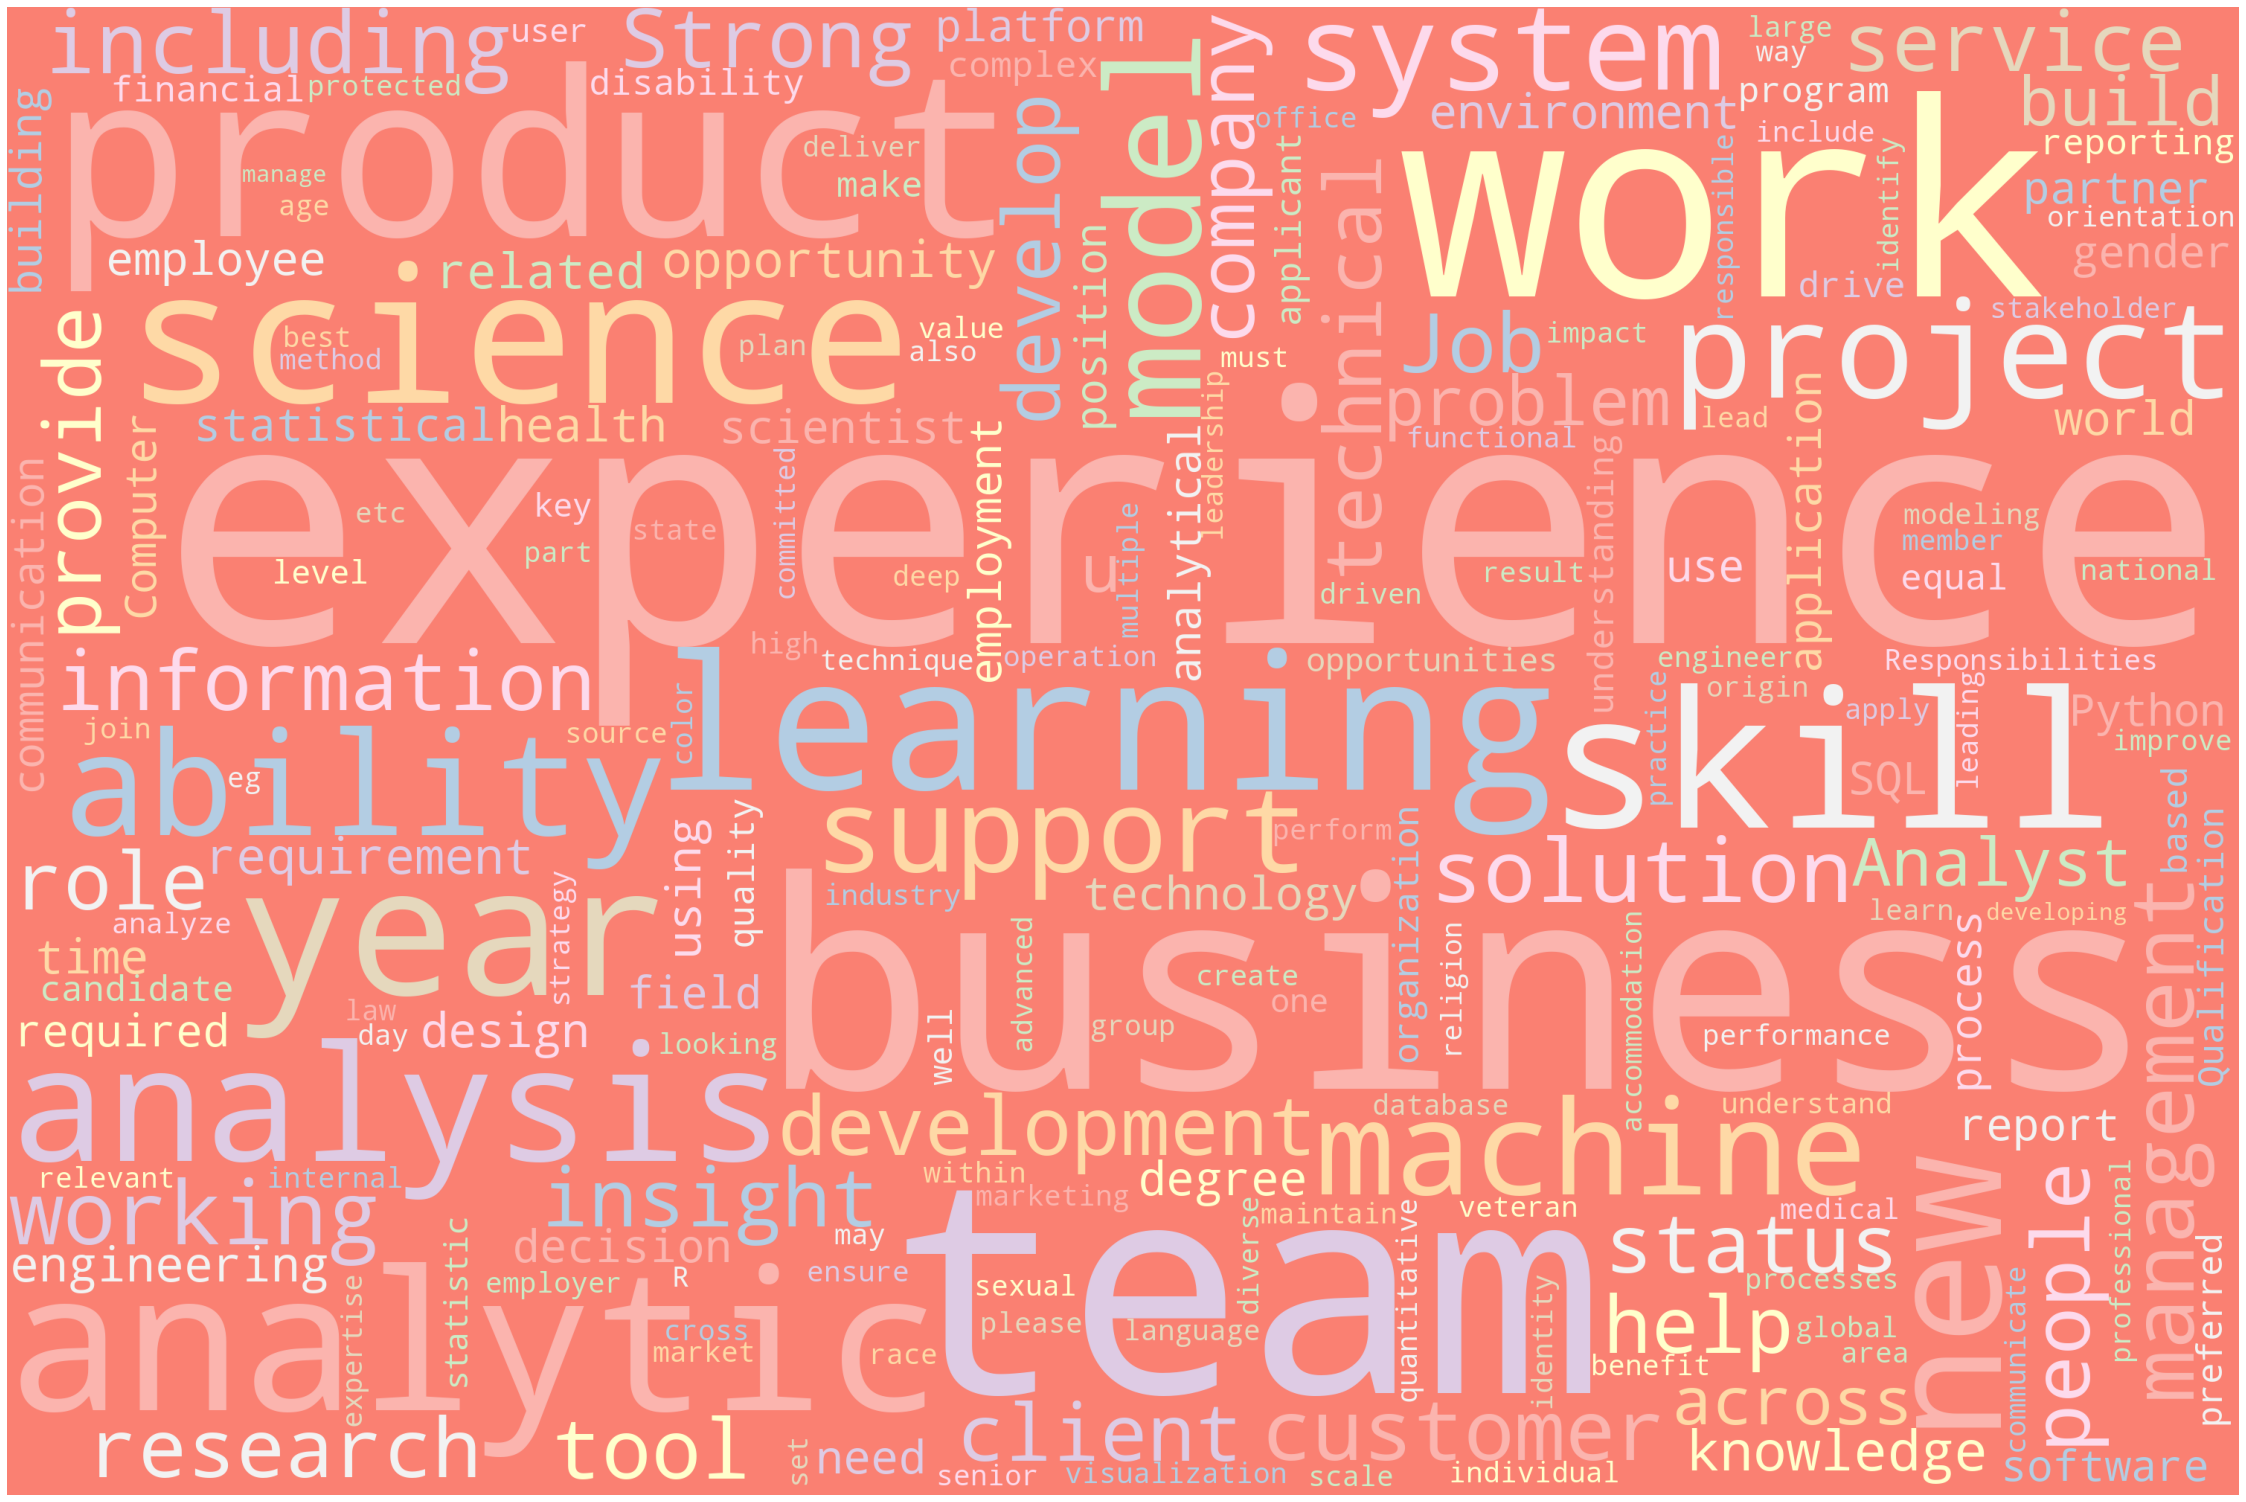

In [11]:
nlp.word_cloud(seq)

In [23]:
bow = nlp.to_wcdf(all_data['Description'])

In [24]:
bow.head()

,00,000,00am,00pm,01,02,03,04,08,09,...,youtu,youtube,yoy,yrs,zendesk,zero,zone,zones,zoom,zoonotic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# LDA

Helpful articles: [1](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2), [2](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-latent-dirichlet-allocation-437c81220158)

Note: A lot of the content here is paraphrased from source 2 above

And the goal of LDA is to map all the documents to the topics in a way, such that the words in each document are mostly captured by those imaginary topics.

We want to solve:

$$
P(\theta_{1:M}, z_{1:M}, \beta_{1:K}|D:\alpha_{1:M},\eta_{1:k})
$$

This is just saying:

    I have a set of M documents, each document having N words, where each word is generated by a single topic from a set of K topics. I’m looking for the joint posterior probability of


Each document can be described by a distribution of topics and each topic can be described by a distribution of word



$\theta$ (distributional parameter) or $P(\text{topic } t|\text{document } d)$: 
_The proportion of words in document d that are assigned to topic t. This tries to capture how many words belong to topic t for a given document d excluding the current word. If a lot of words from d belong to t, there is a higher probability that word w belongs to t._

Next we have:

$\beta$ (distributional parameter) or $P(\text{word } w|\text{topic } t)$: _The proportion of assignments to topic t over all documents that come from this word w. This tries to capture how many documents are in topic t because of the word w._

* k — Number of topics a document belongs to (a fixed number)
* V — Size of the vocabulary
* M — Number of documents
* N — Number of words in each document
* w — A word in a document. This is represented as a one hot encoded vector of size V (i.e. V — vocabulary size)
* w (bold w): represents a document (i.e. vector of “w”s) of N words
* D — Corpus, a collection of M documents
* z — A topic from a set of k topics. A topic is a distribution words. For example it might be, Animal = (0.3 Cats, 0.4 Dogs, 0 AI, 0.2 Loyal, 0.1 Evil)


One of the way to solve this is through a Variational Inference optimization problem!

For this research project, I will be referencing [this](https://github.com/kapadias/mediumposts/blob/master/natural_language_processing/topic_modeling/notebooks/Introduction%20to%20Topic%20Modeling.ipynb) implementation.

In [ ]:
# Remove punctuation/lower casing


# Non-negative Matrix Factorization

Now, I will try to apply a matrix factorization to the dataframe. We start by reproducing the documentation example:

In [16]:
def matrix_factorization(R, P, Q, K, steps=5000, 
                alpha=0.0002, beta=0.02):
    
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        P[i][k] = P[i][k] + alpha * (2 * eij * 
                                Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * 
                            eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) 
                                + pow(Q[k][j],2))
        if e < 0.001:
            break
    return P, Q.T



In [17]:
R = [
     [5,3,0,1],
     [4,0,0,1],
     [1,1,0,5],
     [1,0,0,4],
     [0,1,5,4],
    ]
 
R = np.array(R)

N = len(R)
M = len(R[0])
K = 2
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
 
nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)



In [20]:
print(R)
print("~~~~~~~~~~~~~~~~")
print(P)
print("~~~~~~~~~~~~~~~~")
print(Q)
print("~~~~~~~~~~~~~~~~")
print(nR)

[[5 3 0 1]
 [4 0 0 1]
 [1 1 0 5]
 [1 0 0 4]
 [0 1 5 4]]
~~~~~~~~~~~~~~~~
[[2.33735152 0.47536955]
 [1.80806381 0.45771185]
 [0.21727692 1.95025949]
 [0.18472065 1.56432009]
 [1.00075232 1.61346181]]
~~~~~~~~~~~~~~~~
[[ 2.08466052  0.35059526]
 [ 1.15747719  0.20067333]
 [ 2.25704927  1.60109912]
 [-0.0935873   2.5551066 ]]
~~~~~~~~~~~~~~~~
[[5.03924674 2.80082506 6.03663132 0.99587344]
 [3.92967083 2.18464317 4.81373115 1.00029077]
 [1.13670033 0.64285814 3.61296347 4.96278653]
 [0.93352305 0.52772727 2.92155513 3.97971707]
 [2.6519009  1.48212674 4.84205958 4.02890921]]
